In [1]:
import os
import geopandas as gpd
import rasterio
from shapely.geometry import box

In [2]:
# Input Folders
geotiff_path = r'image_geotiff'
shapefile_og_path = r'shapefile_og'

# Output Folders
shapefile_new_path = r'shapefile_new'
raster_mask_path = r'raster_mask'
tile_path = r'image_and_mask_tiles'

## Create new shapefile from original shapefile
This function clips the polygons from a shapefile to the bounding box of a given GeoTIFF and saves the result as a new shapefile.

In [3]:
def create_new_shapefile(geotiff_path, shapefile_path, output_shapefile_path):
    # Read the GeoTIFF to get the bounding box
    with rasterio.open(geotiff_path) as src:
        bounds = src.bounds
        geotiff_crs = src.crs

    # Read the shapefile
    shapefile = gpd.read_file(shapefile_path)

    # Ensure the shapefile is in the same CRS as the GeoTIFF
    if shapefile.crs != geotiff_crs:
        shapefile = shapefile.to_crs(geotiff_crs)

    # Create the bounding box polygon for the GeoTIFF
    geotiff_bbox = box(bounds.left, bounds.bottom, bounds.right, bounds.top)

    # Clip polygons from the shapefile to the GeoTIFF bounding box
    clipped_polygons = gpd.clip(shapefile, geotiff_bbox)

    # Save the new shapefile
    clipped_polygons.to_file(output_shapefile_path)

In [4]:
for image_name in os.listdir(geotiff_path):
    poly_mask_name , _ = image_name.split('.')
    poly_mask_name = poly_mask_name + '.shp'

    tiff_path = os.path.join(geotiff_path,image_name)
    output_shapefile_path = os.path.join(shapefile_new_path,poly_mask_name)

    create_new_shapefile(tiff_path, shapefile_og_path, output_shapefile_path)


## Shapefile to Raster Mask

This code matches vector shapefiles with corresponding satellite raster images based on their filenames, then generates and saves mask images by rasterizing the shapefiles to the extent of the satellite images, and finally converts the resulting GeoTIFFs to PNG format.

In [5]:
import os
os.environ['CURL_CA_BUNDLE']='/etc/ssl/certs/ca-certificates.crt'
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import rasterio.mask
import geopandas as gpd
from osgeo import ogr, gdal
import cv2

In [6]:
# Set folder path for satellite images
root_folder_ras = geotiff_path

# Set folder path for polygon/vector/shapfile
root_folder_vec = shapefile_new_path

# Set folder path for output masking images
root_folder_result = raster_mask_path

temp_dir = os.path.join(root_folder_result, "temp")
if not os.path.exists(temp_dir):
    os.makedirs(temp_dir)

In [7]:
d = 0
vec = []
ras = []
namevec = []
nameras = []

# Append file path/name of vector/shapefile
for root, dirs, files in os.walk(root_folder_vec):
    print("=====Shapefile List=====")
    for filein in files:
        if filein.endswith('.shp'):
            print(filein)
            namevec.append(filein)
            shp_dir = os.path.join(root, filein)
            vec.append(shp_dir)

# Append file path/name of raster (satellite images)
for root1, dirs1, files1 in os.walk(root_folder_ras):
    print("=====satellite images List=====")
    for filein1 in files1:
        if filein1.endswith('.tif'):
            print(filein1)
            shp_dir1 = os.path.join(root1, filein1)
            ras.append(shp_dir1)
            nameras.append(filein1)
print(vec)
print(ras)

# Function: Matching files between satellite and shapefile for generating mask images
def gen_mask(namevec, nameras, vec, ras, d, root_folder_result):
    for i in range(len(nameras)):
        if namevec[d].split('.')[0] == nameras[i].split('.')[0]:
            print('====Matched====', d)
            print('Shapefile : ', namevec[d])
            print('Satellite image : ', nameras[i])

            InputVector1 = vec[d]
            Filename = nameras[i].split('.')[0]
            OutputGeoTIFF = os.path.join(temp_dir, Filename + '.tif')
            OutputPNG = os.path.join(root_folder_result, Filename + '.png')
            RefImage = ras[i]

            # Generate new attribute in shapefile
            gdf = gpd.read_file(InputVector1)
            gdf["pi"] = 1
            temp_shapefile = os.path.join(temp_dir, "NewAttribute.shp")
            gdf.to_file(temp_shapefile)
            InputVector = temp_shapefile
            print('Finished reclass vector')

            gdalformat = 'GTiff'
            datatype = gdal.GDT_Byte
            burnVal = 1  # value for the output image pixels

            # Get projection info from reference image
            Image = gdal.Open(RefImage, gdal.GA_ReadOnly)

            if Image is None:
                raise RuntimeError(f"Failed to open reference image: {RefImage}")

            # Open Shapefile
            Shapefile = ogr.Open(InputVector)
            Shapefile_layer = Shapefile.GetLayer()

            # Rasterizing
            print("Rasterizing vector...")
            try:
                Output = gdal.GetDriverByName(gdalformat).Create(OutputGeoTIFF, Image.RasterXSize, Image.RasterYSize, 1, datatype)
                if Output is None:
                    raise RuntimeError(f"Failed to create output image: {OutputGeoTIFF}")

                Output.SetProjection(Image.GetProjectionRef())
                Output.SetGeoTransform(Image.GetGeoTransform())

                # Write data to band 1
                Band = Output.GetRasterBand(1)
                Band.SetNoDataValue(-999)
                gdal.RasterizeLayer(Output, [1], Shapefile_layer, burn_values=[burnVal])

                # Close datasets
                Band = None
                Output = None
                Image = None
                Shapefile = None

                # Convert GeoTIFF to PNG
                print(f"Converting {OutputGeoTIFF} to PNG...")
                gdal.Translate(OutputPNG, OutputGeoTIFF, format='PNG')
                print(f"Output Mask Image: {OutputPNG}")

                # Check mask image metadata
                raster = rasterio.open(OutputPNG)
                mask_meta = raster.meta
                print("Output Mask Image Metadata: {} \n {}".format(OutputPNG, mask_meta))
                
            except Exception as e:
                print(f"Error rasterizing vector: {e}")

            print("=====Finished rasterize vector=====")

# Generating mask images
for i in range(len(vec)):
    gen_mask(namevec, nameras, vec, ras, d, root_folder_result)
    d += 1

=====Shapefile List=====
VatSaiKhlongSaphanSung_7.shp
=====satellite images List=====
VatSaiKhlongSaphanSung_7.tif
['shapefile_new\\VatSaiKhlongSaphanSung_7.shp']
['image_geotiff\\VatSaiKhlongSaphanSung_7.tif']
====Matched==== 0
Shapefile :  VatSaiKhlongSaphanSung_7.shp
Satellite image :  VatSaiKhlongSaphanSung_7.tif
Finished reclass vector
Rasterizing vector...
Converting raster_mask\temp\VatSaiKhlongSaphanSung_7.tif to PNG...


c:\Users\johnt\anaconda3\envs\shape_to_mask_py310\lib\site-packages\osgeo\gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


Output Mask Image: raster_mask\VatSaiKhlongSaphanSung_7.png
Output Mask Image Metadata: raster_mask\VatSaiKhlongSaphanSung_7.png 
 {'driver': 'PNG', 'dtype': 'uint8', 'nodata': None, 'width': 10000, 'height': 10001, 'count': 1, 'crs': CRS.from_epsg(32647), 'transform': Affine(0.1, 0.0, 671789.9341203858,
       0.0, -0.10000000000000932, 1535540.8589398284)}
=====Finished rasterize vector=====


## Tile image and mask

In [8]:
def tile_image(input_image_path, output_dir, tile_width, tile_height, overlap=0, png_compression=3, is_mask=False):
    # Obtain image name
    image_name = os.path.basename(input_image_path)
    image_name, _ = os.path.splitext(image_name)

    # Ensure output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Read the input image
    image = cv2.imread(input_image_path)
    if image is None:
        raise ValueError(f"Could not read the image from {input_image_path}")
    if is_mask:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Get image dimensions
    img_height, img_width = image.shape[:2]

    # Calculate the number of tiles needed
    x_steps = (img_width - overlap) // (tile_width - overlap)
    y_steps = (img_height - overlap) // (tile_height - overlap)

    # Tile the image
    tile_count = 0
    for y in range(y_steps + 1):
        for x in range(x_steps + 1):
            # Calculate the position of the current tile
            start_x = x * (tile_width - overlap)
            start_y = y * (tile_height - overlap)
            end_x = start_x + tile_width
            end_y = start_y + tile_height

            # Ensure the tile fits the given dimensions
            if end_x <= img_width and end_y <= img_height:
                # Extract the tile
                tile = image[start_y:end_y, start_x:end_x]

                # Generate the output filename
                if is_mask:
                    tile_filename = f'{image_name}_tile_{start_x}_{start_y}_mask.png'
                else:
                    tile_filename = f'{image_name}_tile_{start_x}_{start_y}.png'
                tile_path = os.path.join(output_dir, tile_filename)

                # Save the tile
                cv2.imwrite(tile_path, tile, [cv2.IMWRITE_PNG_COMPRESSION, png_compression])
                tile_count += 1

    if is_mask:
        print(f"Created {tile_count} mask tiles.")
    else:
        print(f"Created {tile_count} image tiles.")


def show_1image(image, size = (10,10)):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=size)
    axes.imshow(image, cmap="summer")
    axes.axis("off")
    plt.show()

In [9]:
dim = 512
png_compression = 6

for image in sorted(os.listdir(geotiff_path)):
    image_name, _= image.split('.')
    output_tile_dir = os.path.join(tile_path, image_name)

    if not os.path.exists(output_tile_dir):
        os.makedirs(output_tile_dir)
    
    image_path = os.path.join(geotiff_path,image)
    mask_path = os.path.join(raster_mask_path,image_name+'.png')

    print('Input image:', image)
    # Tile Image
    print('   ', end='--> ')
    tile_image(image_path, output_tile_dir, dim, dim, overlap=0, png_compression=png_compression,is_mask=False)

    # Tile Mask
    print('   ', end='--> ')
    tile_image(mask_path, output_tile_dir, dim, dim, overlap=0, png_compression=png_compression,is_mask=True)
    

    
    

Input image: VatSaiKhlongSaphanSung_7.tif
   --> Created 361 image tiles.
   --> Created 361 mask tiles.


## Remove image and mask pairs that do not have solar panels

In [10]:

root_dir = tile_path
for dir in sorted(os.listdir(root_dir)):
    cur_dir = os.path.join(root_dir,dir)

    removed_pair = 0
    for mask in sorted(os.listdir(cur_dir)):
        if '_mask' in mask:
            mask_path = os.path.join(cur_dir,mask)
            mask_array = cv2.imread(mask_path)
            if np.unique(mask_array).size != 2:
                os.remove(mask_path)
                os.remove('.'.join(mask_path.split('_mask.')))
                removed_pair = removed_pair + 1
    print(dir, '--> deleted pairs:', removed_pair )


VatSaiKhlongSaphanSung_7 --> deleted pairs: 351


In [11]:
root_path = tile_path
categories_paths = os.listdir(root_path)
categories_paths = [os.path.join(root_path, cat_path) for cat_path in categories_paths]

total_images = 0
for cat_path in categories_paths:
    for _, _, files in os.walk(cat_path):
        print("{}: {}".format(cat_path, len(files)))
        total_images=total_images+len(files)
print('Total images:',int(total_images/2),'/ Total masks:',int(total_images/2))

image_and_mask_tiles\VatSaiKhlongSaphanSung_7: 20
Total images: 10 / Total masks: 10


## Example Showcase

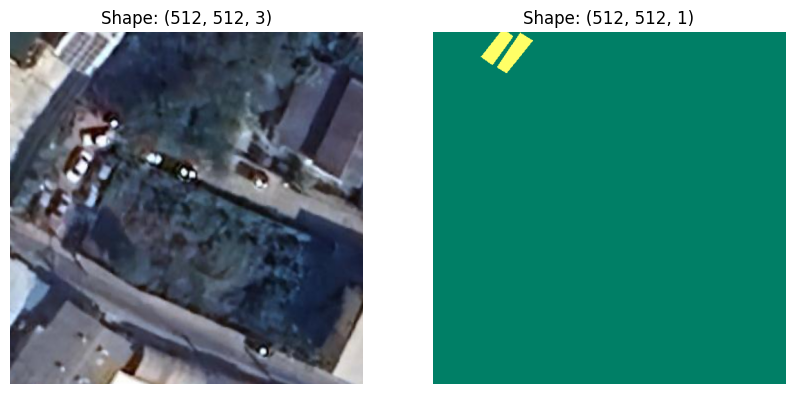

In [12]:
image_path = r'image_and_mask_tiles\VatSaiKhlongSaphanSung_7\VatSaiKhlongSaphanSung_7_tile_3584_2560.png'
mask_path = r'image_and_mask_tiles\VatSaiKhlongSaphanSung_7\VatSaiKhlongSaphanSung_7_tile_3584_2560_mask.png'
image = plt.imread(image_path)
mask = np.expand_dims(plt.imread(mask_path), axis=(-1))
image_shape = image.shape
mask_shape = mask.shape

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 20))

axes[0].imshow(image)
axes[0].set_title('Shape: ' + str(image_shape))

axes[1].imshow(mask, cmap="summer")
axes[1].set_title('Shape: ' + str(mask_shape))

[ax.axis("off") for ax in axes]
plt.show()